# Copernicus Marine dataset

## Feature importance analysis (using XGBoost)

https://help.marine.copernicus.eu/en/articles/8283072-copernicus-marine-toolbox-api-subset

https://pypi.org/project/copernicusmarine/

In [1]:
import copernicusmarine
import os
import pandas as pd
#import shap
%matplotlib inline
import matplotlib.pyplot as plt

# To avoid warning messages
import warnings
warnings.filterwarnings('ignore')

# Import Garbage Collector - we will need it a lot here, since we are dealing with huge files and might have memory issues!
import gc

c:\Users\fbale\anaconda3\envs\NewAtlantis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# You need to log in a Copernicus Marine account to access the data.
copernicusmarine.login()
# Copernicus username and password.

username:password:File C:\Users\fbale\.copernicusmarine\.copernicusmarine-credentials already exists, overwrite it ? [y/N]:

INFO - 2024-07-28T18:16:25Z - Credentials file stored in C:\Users\fbale\.copernicusmarine\.copernicusmarine-credentials.


True

# Read datasets as pandas dataframes

In [3]:
DATASET_NAME = 'cmems_mod_glo_bgc_0.25deg_P1M-m'

oxygen_dataset_id = 'cmems_mod_glo_bgc-bio_anfc_0.25deg_P1M-m'
chlorophyll_dataset_id = 'cmems_mod_glo_bgc-pft_anfc_0.25deg_P1M-m'
chemicals_dataset_id = 'cmems_mod_glo_bgc-nut_anfc_0.25deg_P1M-m'

We are going to consider the month of April 2024 only, for the EDA.

In [4]:
oxygen_df = copernicusmarine.read_dataframe(
    dataset_id = oxygen_dataset_id,
    start_datetime = "2024-01-05",
    end_datetime = "2024-01-04",
)

INFO - 2024-07-28T18:16:25Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-07-28T18:16:25Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-07-28T18:16:29Z - Service was not specified, the default one was selected: "arco-geo-series"


In [5]:
chlorophyll_df = copernicusmarine.read_dataframe(
    dataset_id = chlorophyll_dataset_id,
    start_datetime = "2024-01-05",
    end_datetime = "2024-01-04",
)

INFO - 2024-07-28T18:17:28Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-07-28T18:17:28Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-07-28T18:17:32Z - Service was not specified, the default one was selected: "arco-geo-series"


In [6]:
chemical_df = copernicusmarine.read_dataframe(
    dataset_id = chemicals_dataset_id,
    start_datetime = "2024-01-05",
    end_datetime = "2024-01-04",   
)

INFO - 2024-07-28T18:18:46Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-07-28T18:18:46Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-07-28T18:18:50Z - Service was not specified, the default one was selected: "arco-geo-series"


### Clean datasets and merge them into a unique dataframe

In [7]:
oxygen_df = oxygen_df.dropna().reset_index()
chlorophyll_df = chlorophyll_df.dropna().reset_index()
chemical_df = chemical_df.dropna().reset_index()

In [8]:
merged_df_april_2024__o2_chl_chem__m = oxygen_df.copy()

In [9]:
merged_df_april_2024__o2_chl_chem__m["chl"] = chlorophyll_df["chl"] # Chlorophyll
merged_df_april_2024__o2_chl_chem__m["phyc"] = chlorophyll_df["phyc"] # Picophytoplankton [contributes to Carbon production]
merged_df_april_2024__o2_chl_chem__m["fe"] = chemical_df["fe"] # Iron
merged_df_april_2024__o2_chl_chem__m["no3"] = chemical_df["no3"] # Nitrate Ion
merged_df_april_2024__o2_chl_chem__m["po4"] = chemical_df["po4"] # Phosphate Ion
merged_df_april_2024__o2_chl_chem__m["si"] = chemical_df["si"] # Silicon

In [10]:
# To free some memory space, delete unused dataframes and call the garbage collector
del oxygen_df
del chlorophyll_df
del chemical_df

gc.collect()

80195

# XGBoost for regression

In [11]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

In [12]:
# Extract feature and target arrays
X, y = merged_df_april_2024__o2_chl_chem__m.drop('chl', axis = 1), merged_df_april_2024__o2_chl_chem__m[['chl']]
X = X.drop('time', axis = 1)
X = X.drop('latitude', axis = 1)
X = X.drop('longitude', axis = 1)

gc.collect()

0

In [13]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train, y_train, random_state=1)

del X_train, y_train
gc.collect()

0

### Train XGBoost Regressor (Scikit-learn version)

In [14]:
xgb_reg_model = XGBRegressor(n_estimators = 1000, verbosity = 0, random_state = 1, early_stopping_rounds = 50, eval_metric = 'rmse', device = 'cuda')
xgb_reg_model.fit(X_train_train, y_train_train, eval_set = [(X_train_train, y_train_train), (X_train_test, y_train_test)])

[0]	validation_0-rmse:0.15220	validation_1-rmse:0.15191
[1]	validation_0-rmse:0.11221	validation_1-rmse:0.11195
[2]	validation_0-rmse:0.08497	validation_1-rmse:0.08476
[3]	validation_0-rmse:0.06713	validation_1-rmse:0.06702
[4]	validation_0-rmse:0.05577	validation_1-rmse:0.05571
[5]	validation_0-rmse:0.04815	validation_1-rmse:0.04816
[6]	validation_0-rmse:0.04336	validation_1-rmse:0.04344
[7]	validation_0-rmse:0.04047	validation_1-rmse:0.04061
[8]	validation_0-rmse:0.03839	validation_1-rmse:0.03858
[9]	validation_0-rmse:0.03713	validation_1-rmse:0.03733
[10]	validation_0-rmse:0.03603	validation_1-rmse:0.03627
[11]	validation_0-rmse:0.03522	validation_1-rmse:0.03548
[12]	validation_0-rmse:0.03429	validation_1-rmse:0.03457
[13]	validation_0-rmse:0.03394	validation_1-rmse:0.03422
[14]	validation_0-rmse:0.03340	validation_1-rmse:0.03369
[15]	validation_0-rmse:0.03300	validation_1-rmse:0.03329
[16]	validation_0-rmse:0.03251	validation_1-rmse:0.03282
[17]	validation_0-rmse:0.03222	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=1, ...)

In [15]:
gc.collect()

43

In [16]:
xgb_reg_model.save_model("xgb_reg_model_1000_April_Copernicus.json")

In [17]:
predictions = xgb_reg_model.predict(X_test)

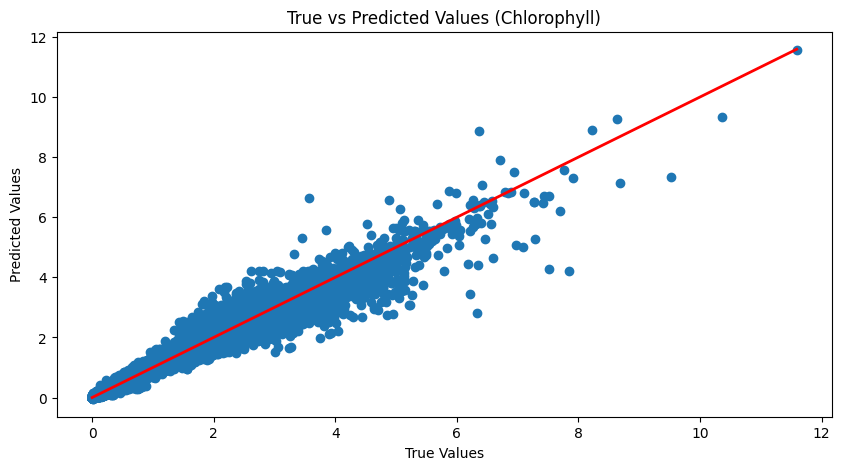

In [18]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red',  linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values (Chlorophyll)')
plt.show()

# Set up folder for storing the various feature importance plots for XGBoost

In [19]:
CURR_DIR = os.getcwd()

feat_imp_plots_path = CURR_DIR + f"\\feat_imp_plots_{DATASET_NAME}\\"
if not os.path.exists(feat_imp_plots_path):
    os.mkdir(feat_imp_plots_path)

shap_plots_path = CURR_DIR + f"\\shap_plots_{DATASET_NAME}\\"
if not os.path.exists(shap_plots_path):
    os.mkdir(shap_plots_path)

permutation_imp_plots_path = CURR_DIR + f"\\permutation_imp_plots_{DATASET_NAME}\\"
if not os.path.exists(permutation_imp_plots_path):
    os.mkdir(permutation_imp_plots_path)

# Feature importance: WEIGHT, GAIN, COVER

For XGBoost, we are consider the following three feature importance types: WEIGHT, GAIN, and COVER. For more explanation, see  https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7 .
We are going to select the features from the training set (and not the whole set); see e.g. https://stackoverflow.com/questions/56308116/should-feature-selection-be-done-before-train-test-split-or-after


In [20]:
def create_feature_importance_type_df(model, FEATURE_CONSIDERED):
    list_feat = list(model.get_booster().get_score(importance_type = FEATURE_CONSIDERED).items())
    feat_df = pd.DataFrame(list_feat, columns=['feature',f'importance ({FEATURE_CONSIDERED})']).sort_values(f'importance ({FEATURE_CONSIDERED})', ascending = False)
    total = feat_df[f"importance ({FEATURE_CONSIDERED})"].sum()
    feat_df["proportion"] = feat_df[f"importance ({FEATURE_CONSIDERED})"].div(total)
    gc.collect()
    return feat_df, list_feat

In [21]:
def plot_feature_importance(model, FEATURE_CONSIDERED, COLOUR, save_plot_path):

    df, list_feat = create_feature_importance_type_df(model, FEATURE_CONSIDERED)
    print(df.head(len(list_feat)))

    df = df.set_index('feature').sort_values('proportion')

    # Build horizontal bar char
    ax = df.plot.barh(color=COLOUR, alpha=0.5, grid=True, legend=False, title=f'Feature importance ({FEATURE_CONSIDERED})', figsize=(15, 5))

    # Annotate bar chart, adapted from this SO answer:
    # https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots
    for p, value in zip(ax.patches, df['proportion']):
        ax.annotate(round(value, 2), (p.get_width() * 1.005, p.get_y() * 1.005))
    
    plt.savefig(save_plot_path + f"\\plot_feat_importance_{FEATURE_CONSIDERED}.png")

    gc.collect()

  feature  importance (weight)  proportion
4      fe               8974.0    0.146206
2      o2               8737.0    0.142345
7      si               8451.0    0.137686
6     po4               8033.0    0.130875
5     no3               7830.0    0.127568
3    phyc               6892.0    0.112286
1    nppv               6778.0    0.110429
0   depth               5684.0    0.092605
  feature  importance (gain)  proportion
3    phyc         117.185448    0.592153
1    nppv          50.043633    0.252877
4      fe          11.871438    0.059988
5     no3          11.413186    0.057672
0   depth           2.890857    0.014608
2      o2           2.586265    0.013069
7      si           1.061174    0.005362
6     po4           0.845081    0.004270
  feature  importance (cover)  proportion
3    phyc         3526052.750    0.274367
1    nppv         2653833.250    0.206498
6     po4         1444528.750    0.112401
4      fe         1280858.125    0.099665
5     no3         1227239.250    0

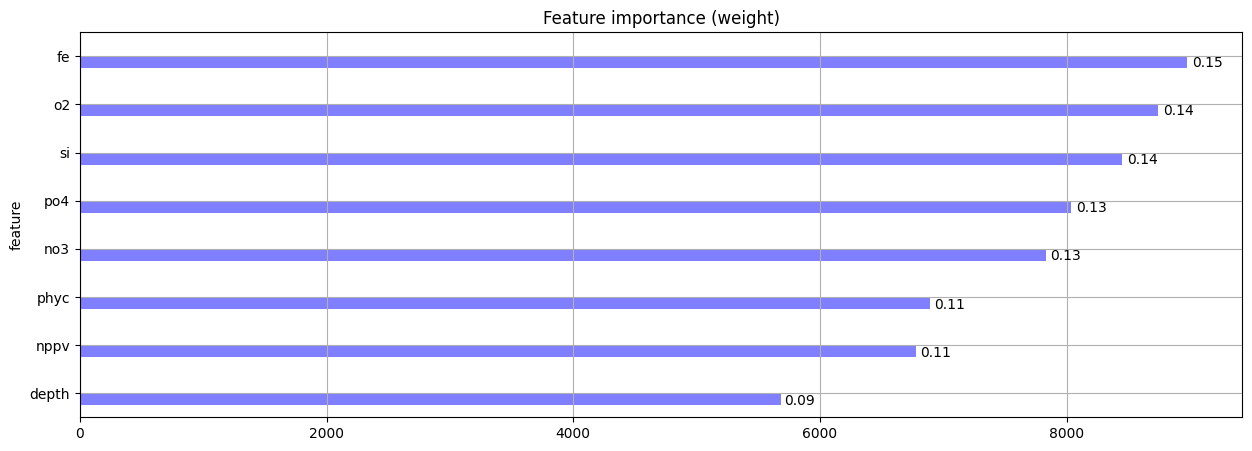

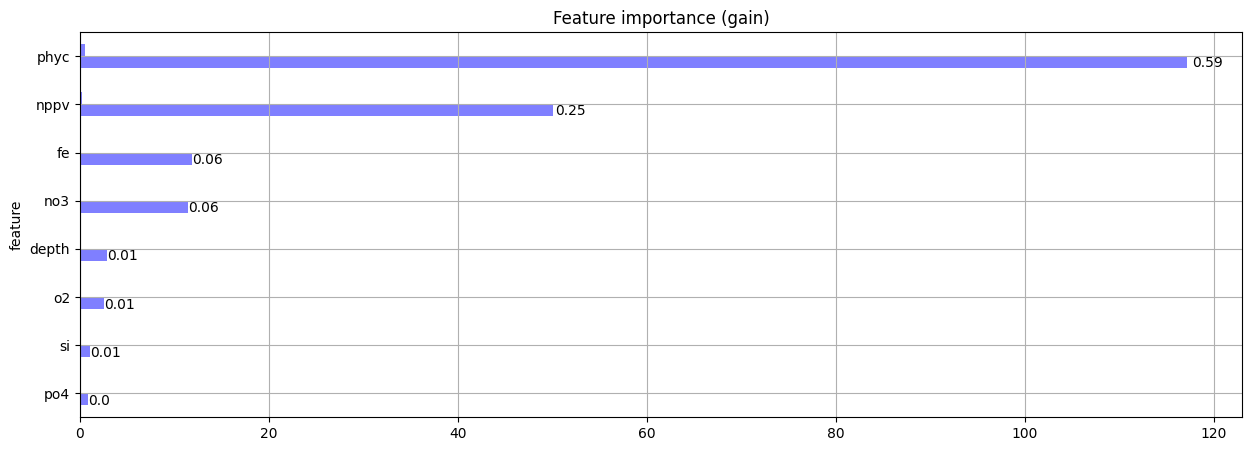

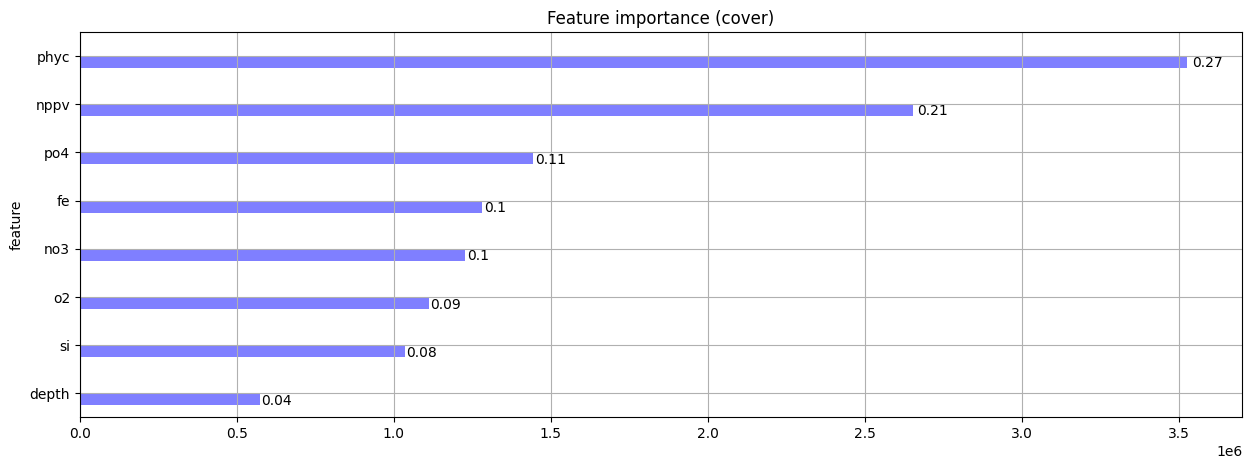

In [22]:
FEAT_IMP_TYPES = ["weight", "gain", "cover"]

for feat_imp_type in FEAT_IMP_TYPES:
    plot_feature_importance(xgb_reg_model, feat_imp_type, "blue", feat_imp_plots_path)
    gc.collect()

# Feature importance: SHAP

In [23]:
import shap

In [24]:
explainer = shap.TreeExplainer(xgb_reg_model)
shap_values = explainer.shap_values(X_train_test)
gc.collect()

45

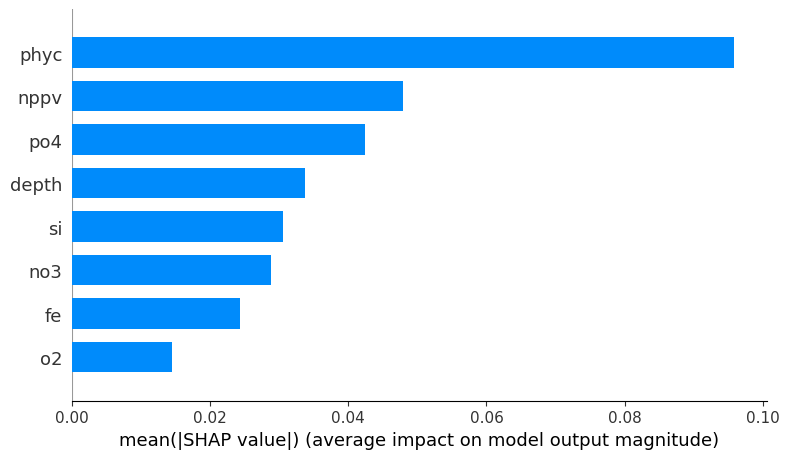

In [25]:
shap.summary_plot(shap_values, X_train_test, plot_type="bar", show = False)
plt.savefig(shap_plots_path +  "\\shap_bar_plot.png")
plt.show()


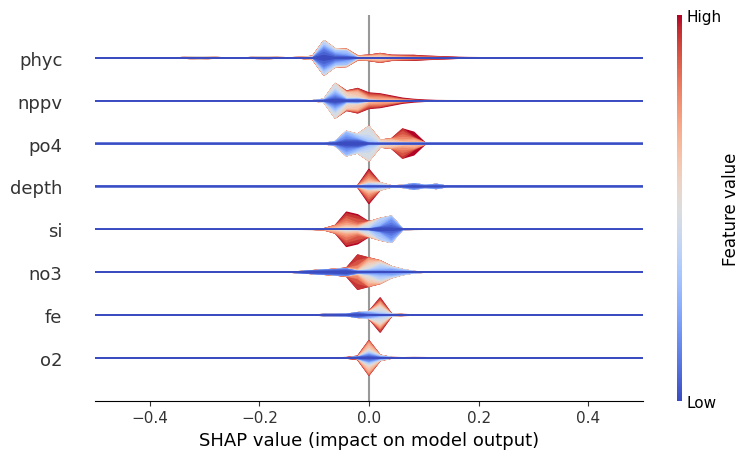

In [26]:
feat_names = list(X_train_test.columns)
shap.summary_plot(shap_values, X_train_test, feature_names=feat_names, plot_type="layered_violin", show = False)
#https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/violin.html
ax = plt.gca()
ax.set_xlim(-0.5, 0.5)
plt.savefig(shap_plots_path + "\\shap_layered_violin_plot.png")
plt.show()

In [27]:
gc.collect()

100

#### Plot shap dependency plots

In [28]:
# Plot the graph shap_values vs actual values
# Consider the top k features that might interact with the selected feature, and draw plots
def plot_shap_dependency_top_k(shap_values, X, FEATURE, k, save_plots, out_save_path):
    inds = shap.approximate_interactions(FEATURE, shap_values, X)
    # make plots colored by each of the top three possible interacting features
    for i in range(k):
        shap.dependence_plot(FEATURE, shap_values, X, interaction_index=inds[i], show = False)
        if save_plots:
            plt.savefig(out_save_path + f'\\shap_dependency_plot_{FEATURE}_{i}.png')
        plt.show()
        gc.collect()

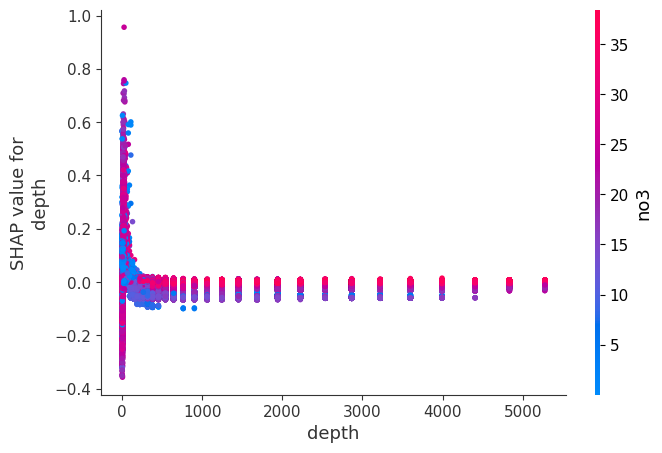

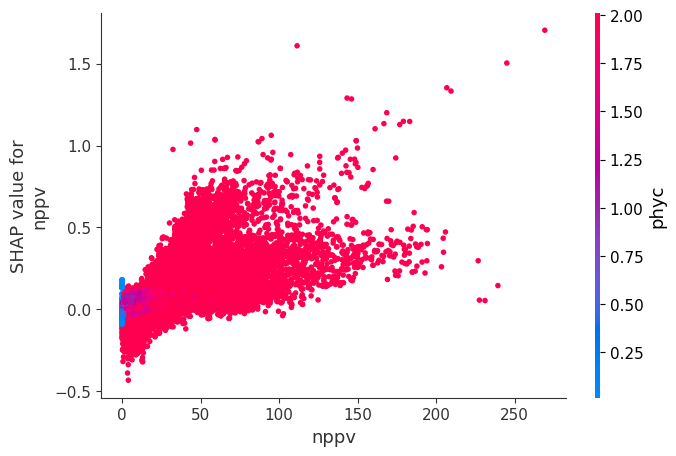

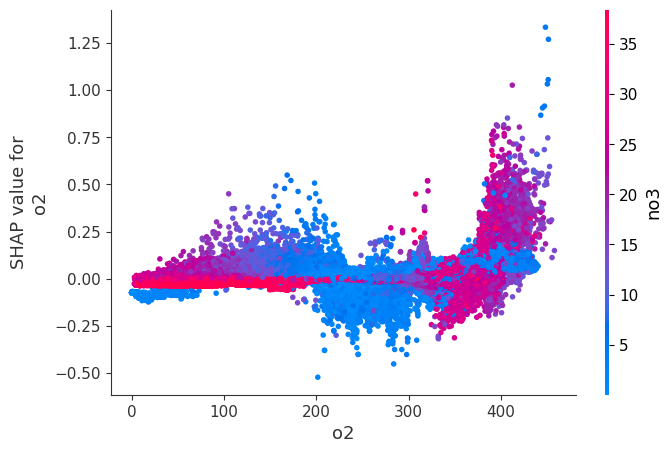

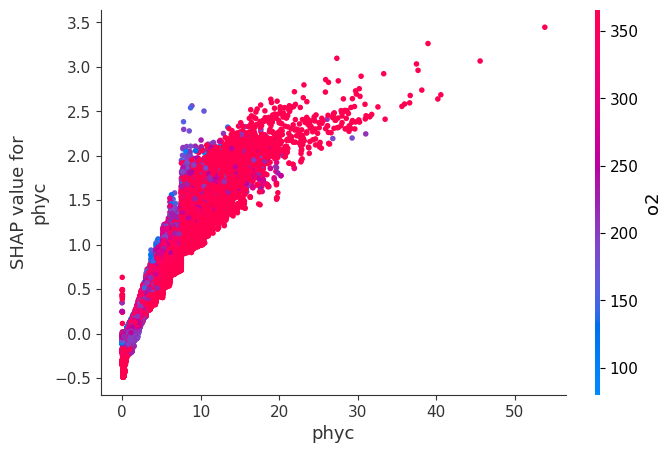

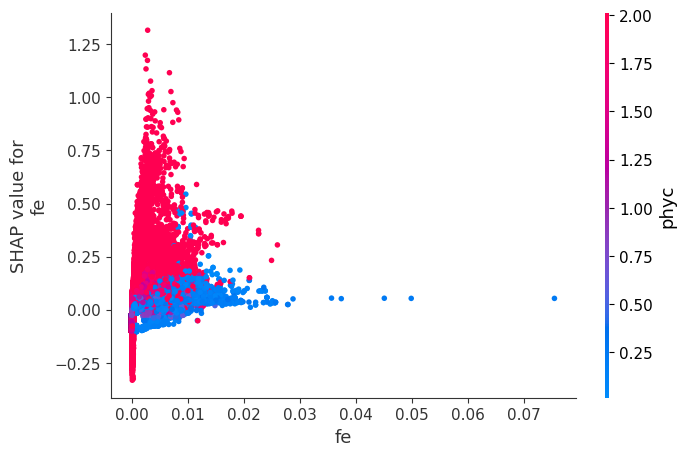

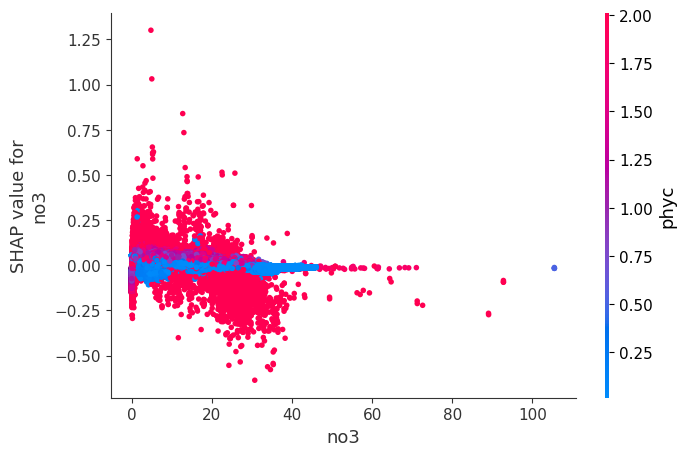

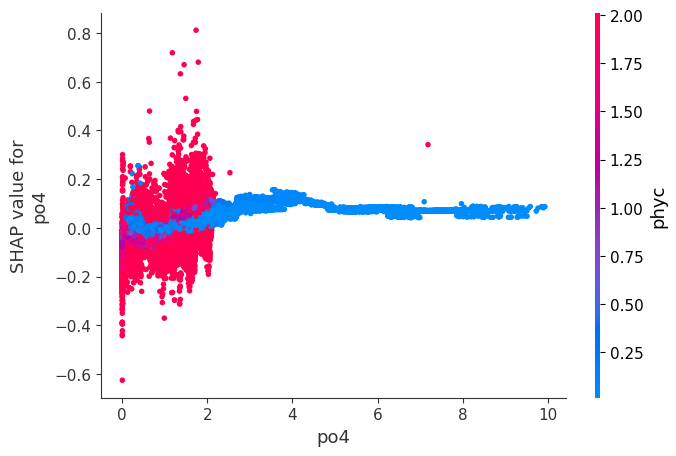

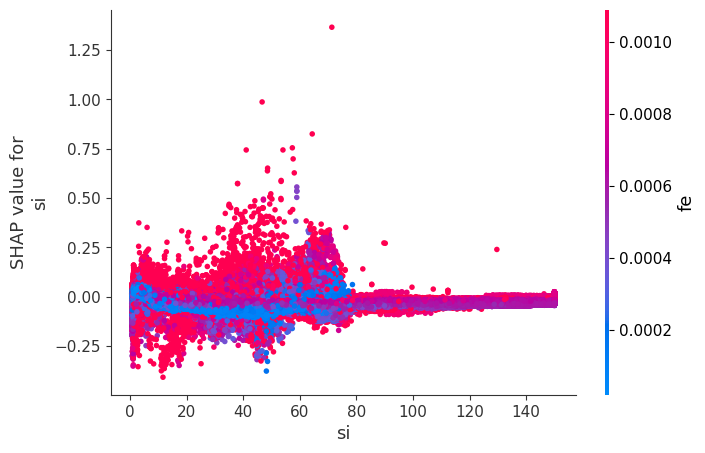

In [29]:
feat_names = list(X_test.columns)

for feat_name in feat_names:
    plot_shap_dependency_top_k(shap_values, X_train_test, feat_name, 1, True, shap_plots_path)
    gc.collect()

# Feature importance: permutation feature importance

https://christophm.github.io/interpretable-ml-book/feature-importance.html

https://mljar.com/blog/feature-importance-xgboost/

In [30]:
from sklearn.inspection import permutation_importance
import seaborn as sns

In [31]:
perm_importance = permutation_importance(xgb_reg_model, X_train_test, y_train_test)
feat_names = list(X_train_test.columns)
feat_names

['depth', 'nppv', 'o2', 'phyc', 'fe', 'no3', 'po4', 'si']

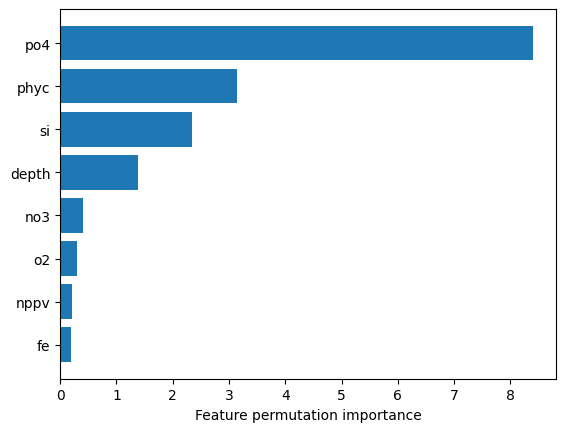

In [32]:
sorted_idx = perm_importance.importances_mean.argsort()
feat_names_sorted = [feat_names[i] for i in sorted_idx]
plt.barh(feat_names_sorted, perm_importance.importances_mean[sorted_idx])
plt.xlabel("Feature permutation importance")
plt.savefig(permutation_imp_plots_path + f"\\permutation_importance_plot.png")

In [33]:
def correlation_heatmap(X_train_feats, plots_save_path): 
    correlations = X_train_feats.corr()
    _, _ = plt.subplots(figsize = (10,10))
    sns.heatmap(correlations, vmax = 1.0, center = 0, fmt = '.2f', cmap = "YlGnBu", square = True, linewidths = 0.5, annot = True, cbar_kws = {"shrink": .70})
    plt.savefig(plots_save_path + f"\\permutation_importance_heatmap.png")
    plt.show()

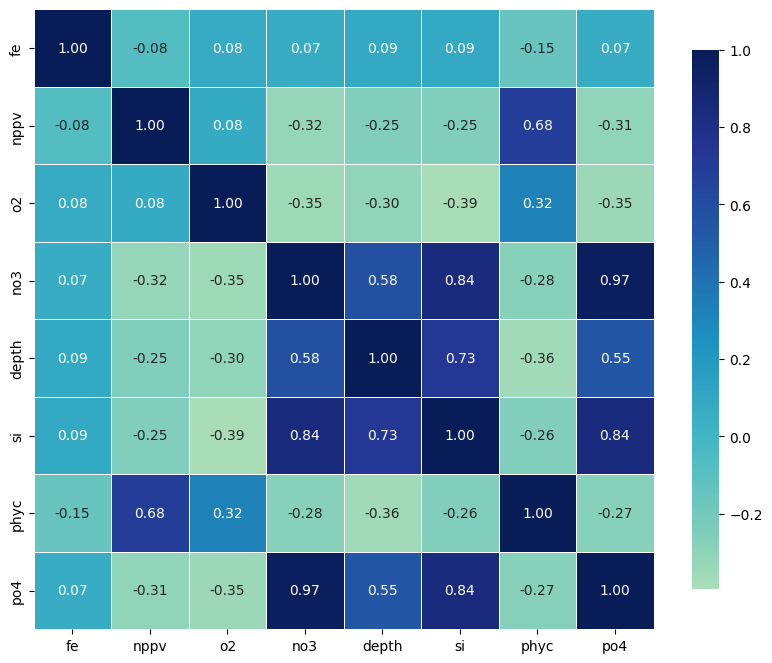

In [34]:
correlation_heatmap(X_train_train[feat_names_sorted], permutation_imp_plots_path)